# Problem set 4: Analyzing data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

import pandas as pd
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

# Tasks

## Import national account data from Denmark Statistics

Consider the following dictionary definitions:

In [3]:
columns_dict = {}
columns_dict['TRANSAKT'] = 'variable'
columns_dict['PRISENHED'] = 'unit'
columns_dict['TID'] = 'year'
columns_dict['INDHOLD'] = 'value'

var_dict = {} # var is for variable
var_dict['P.1 Output'] = 'Y'
var_dict['P.3 Final consumption expenditure'] = 'C'
var_dict['P.3 Government consumption expenditure'] = 'G'
var_dict['P.5 Gross capital formation'] = 'I'
var_dict['P.6 Export of goods and services'] = 'X'
var_dict['P.7 Import of goods and services'] = 'M'

unit_dict = {}
unit_dict['2010-prices, chained values'] = 'real'
unit_dict['Current prices'] = 'nominal'

**Step 1:** Download all of table `nah1`.

In [5]:
# hint, nah1_api = DstApi('?') 
# hint, params = nah1_api._define_base_params(language='en')

# nah1 = nah1_api.get_data(?)

**Step 2:** Rename the columns using `columns_dict` and replace data using `var_dict` and `unit_dict`.

In [6]:
# hint, nah1_true.rename(?,inplace=True)

# for key,value in var_dict.items():
#   nah1.variable.replace(?)

#for key,value in unit_dict.items():
#   nah1.unit.replace(?)

**Step 3:** Only keep rows where the variable is in `[Y, C, G, I, X, M]`. Afterwards convert the `value` column to a float.

In [7]:
# write you code here
# nah1.value = nah1.value.astype('float')

**Step 4:** Discuss what the following summary statistics show.

In [8]:
# nah1.groupby(['variable','unit']).describe()

**Step 5:** Sort the dataset by year

In [9]:
# nah1.sort_values(by='?',inplace=?)
# nah1.head()

**Answer:** See A1.py

## Merge with population data from Denmark Statistics

Load population data from Denmark Statistics:

In [10]:
FT_api = DstApi('FT')
params = FT_api._define_base_params(language='en')
params['variables'][0]['values'] = ['000'] 
## 000 is the code for all of Denmark, this can be seen by using: FT_api.variable_levels('HOVEDDELE', language='en')
pop = FT_api.get_data(params=params)

pop.rename(columns={'TID':'year','INDHOLD':'population'},inplace=True)
pop =  pop.loc[:,['year','population']]
pop.head()

,year,population
0,2010,5534738
1,1769,797584
2,1840,1289075
3,1860,1608362
4,1901,2449540


**Question 1:** Merge the population and the national account data, so there is a new column called `population`. Use the **merge function**.

In [11]:
# hint, merged = pd.merge(?,?,how='?',on=[?])
# merged_true.tail(10)

**Answer:** See A2.py

**Question 2:** Merge the population on again, so there is a new column called `population_alt`. Use the **join method**.

In [77]:
# pop_with_index = pop.set_index(?)
# pop_with_index.rename(columns={'population':'population_alt'},inplace=True)
# merged_with_index = merged.set_index(?)
# merged_alt = merged_with_index.join(?)
# merged_alt.tail(10)

**Answer:** See A3.py

## Split-apply-combine-(plot)

Consider the following **split-apply-combine-plot:**

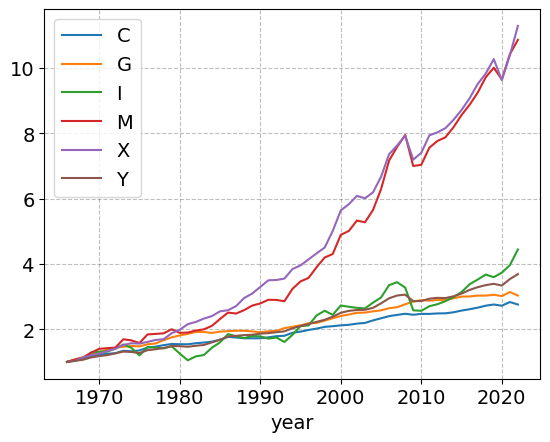

In [ ]:
# a. split
nah1_true_grouped = nah1_true.groupby(['variable','unit'])
nah1_true_grouped_first = nah1_true_grouped.value.first()
nah1_true_grouped_first.name = 'first'

# b. apply
nah1_true.set_index(['variable','unit','year'],inplace=True)
nah1_true = nah1_true.join(nah1_true_grouped_first,how='left',on=['variable','unit'])
nah1_true.reset_index(inplace=True)

# c. combine
nah1_true['indexed'] = nah1_true['value']/nah1_true['first']

# d. plot
def plot(df,variable='indexed'):
    df_indexed = df.set_index('year')
    I = df_indexed.unit == 'real'
    df_indexed[I].groupby(['variable'])[variable].plot(legend=True);
    
plot(nah1_true)

**Question** Implement the same split-apply-combine as above using `transform`.

In [80]:
def first(x): # select the first element in a series
    return x.iloc[0]

# nah1_alt = nah1.copy()
# grouped = nah1_alt.groupby(?)
#nah1_alt[?] = ?.transform(lambda x: ?)
#nah1_alt.head()

In [81]:
# plot(nah1_alt,variable='index_transform')

**Answer:** See A4.py

# Problem: The Housing market


## Housing data

**Note:** The file `data/bm010_parcel.xlsx` has been downloaded from http://rkr.statistikbank.dk/201.

**Question:** Go through the cell below and ensure you understand ALL commands.

In [82]:
# a. load data
prices = pd.read_excel('data/bm010_parcel.xlsx', skiprows=2)
prices.rename(columns={'Unnamed: 2': 'municipality'}, inplace=True)

# b. delete columns
del prices['Unnamed: 0']
del prices['Unnamed: 1']

# c. rename time columns: 1992K1 -> price19921
time_dict = {} 
for y in range(1992,2021+1): 
    for k in range(1,4+1): 
        str_from = f'{y}K{k}'
        str_to   = f'price{y}{k}'
        time_dict[str_from] = str_to
prices = prices.rename(columns = time_dict)        

# d. drop missing
prices = prices.dropna()

# e. convert to long
prices_long = pd.wide_to_long(prices, stubnames='price', i='municipality', j='year_quarter')
prices_long.reset_index(inplace=True)

# f. drop missing and convert to float
I = prices_long.loc[prices_long.price == '..']
prices_long.drop(I.index, inplace=True)
prices_long.price = prices_long.price.astype('float')

# g. create date variable
prices_long['d'] = (prices_long.year_quarter.astype(str).str[:4] # grab the year, first four digits
          + 'Q' # add the letter Q 
          + prices_long.year_quarter.astype(str).str[4]) # the quarter (fifth digit)
prices_long['date'] = pd.PeriodIndex(prices_long.d,freq='Q').to_timestamp() # Convert to datetime
# prices_long['date'] = pd.to_datetime(prices_long.d) This works just as well but throws a warning


# h. cleanup 
del prices_long['year_quarter']
del prices_long['d']

prices_long.head()

,municipality,price,date
0,Hele landet,4021.0,1992-01-01
1,Region Hovedstaden,5836.0,1992-01-01
2,Landsdel København by,5658.0,1992-01-01
3,København,5355.0,1992-01-01
4,Frederiksberg,5183.0,1992-01-01


## Population data

**Question:** Go through the cell below and ensure you understand ALL commands.

In [83]:
# a. Initiate dstapi 
folk1a_api = DstApi('FOLK1A')

# b. Define which data to load
params = folk1a_api._define_base_params(language='en')
params['variables'][1]['values'] = ['TOT']
params['variables'][2]['values'] = ['IALT']
params['variables'][3]['values'] = ['TOT']

# c. Load data
pop = folk1a_api.get_data(params=params)


# d. drop and rename columns
for v in ['ALDER', 'CIVILSTAND', 'KØN']: 
    del pop[v]
pop = pop.rename(columns = {'INDHOLD':'population', 'OMRÅDE': 'municipality'})

# e. drop non-municipalities
for val in ['Region', 'All']: 
    I = pop['municipality'].str.contains(val)
    pop.drop(pop[I].index, inplace=True)

# f. convert to date
pop['date'] = pd.PeriodIndex(pop.TID,freq='Q').to_timestamp() # Convert to datetime
del pop['TID']

pop.head()

,municipality,population,date
0,Furesø,40944,2018-04-01
1,Brøndby,34084,2012-01-01
2,Langeland,12553,2017-04-01
3,Guldborgsund,61130,2018-04-01
4,Hillerød,50636,2018-04-01


## Analysis

**Problem:** Analyze the co-variation betwen population growth and house price growth. Reproduce the graphs below. 

**Hint:** For the second one consider the `agg` method (similar to but different from `transform`, Google it).

In [84]:
# write your code here 

**Answer:** See A5.py for difference in population within municipality. See A6.py for average difference within municipality

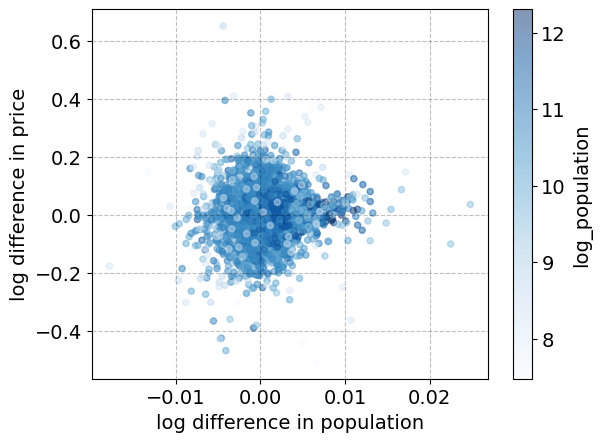

In [97]:
# Run is jupyer magic for running py files inside a notebook
%run -i A5.py

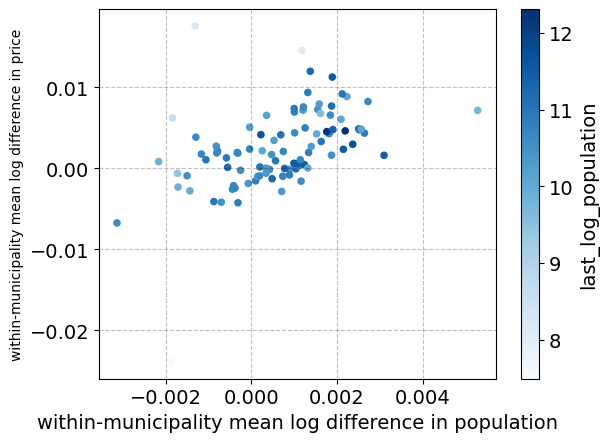

In [98]:
# Run is jupyer magic for running py files inside a notebook
%run -i A6.py